# Growth Rate Computation of MPAS Experiments

## import package

In [1]:
import sys
import numpy as np
import joblib as jl

from matplotlib import pyplot as plt

sys.path.append('/home/b11209013/Package/')
import Theory as th # type: ignore
import DataProcess as dp # type: ignore
import SignalProcess as sp # type: ignore

## Functions

### Covariance

In [2]:
ft = sp.Fourier()

def Covariance(data1, data2):
    
    cs = ft.CrossSpectrum(data1, data2)

    cs_smooth = np.empty(cs.shape, dtype = complex)
    
    kernel = np.array([1, 2, 1]) / 4
    
    for i in range(cs.shape[0]):
        cs_smooth[i] = np.convolve(cs[i], kernel, mode='same')
    
    for i in range(cs.shape[1]):
        cs_smooth[:, i] = np.convolve(cs_smooth[:, i], kernel, mode='same')
    
    return cs_smooth

### Phase

In [3]:
def Phase(data1, data2):
    
    cs = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data1.shape[0])
    ])
    
    phase = np.atan2(cs.imag, cs.real)
    
    return phase

### Growth Rate

In [4]:
def Growth_Rate(data1, data2):
    
    var = np.array([
        Covariance(data2[i], data2[i]).real
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    cov = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    
    sigma = 2*np.real(cov) / var
    
    return sigma

### Coherence Square

In [5]:
def Coherence(data1, data2):
    
    var1 = np.array([
        Covariance(data1[i], data1[i]).real
        for i in range(data1.shape[0])
    ]).mean(axis=0)
    var2 = np.array([
        Covariance(data2[i], data2[i]).real
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    cov  = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data1.shape[0])
    ]).mean(axis=0)
    
    Coh2 = ((cov.real)**2 + (cov.imag)**2) / (var1 * var2)

    return Coh2

## Load data

In [6]:
# case name
case: str = 'NSC'

# path
fname: str = f'/work/b11209013/2024_Research/MPAS/PC/{case}_PC.joblib'

# load data
data: dict = jl.load(fname)

# extract data
pc: dict[str: np.ndarray] = {}

lon : np.ndarray = data['lon']
lat : np.ndarray = data['lat']
time: np.ndarray = data['time']

pc['tpc1']  = data['pc1']['t']
pc['tpc2']  = data['pc2']['t']
pc['q1pc1'] = data['pc1']['q1']
pc['q1pc2'] = data['pc2']['q1']

## Process Data

### Format data

In [7]:
fmt = dp.Format(lat)

ps_sym = {
    var: fmt.sym(pc[var])
    for var in pc.keys()
}

### Windowing data

In [8]:
Hann_windowing = np.hanning(120)[:, None]

ps_hann = {
    var: np.array([
        ps_sym[var][i*60:i*60+120] * Hann_windowing
        for i in range(5)
        ])
    for var in pc.keys()
}


## Compute Variables}

In [9]:
phase = {
    'pc1': Phase(ps_hann['tpc1'], ps_hann['q1pc1']),
    'pc2': Phase(ps_hann['tpc2'], ps_hann['q1pc2'])
}

### Growth Rate

In [10]:
sigma = {
    'pc1': Growth_Rate(ps_hann['q1pc1'], ps_hann['tpc1']),
    'pc2': Growth_Rate(ps_hann['q1pc2'], ps_hann['tpc2']),
}

### Coherence Square

In [11]:
Coh2 = {
    'pc1': Coherence(ps_hann['q1pc1'], ps_hann['tpc1']),
    'pc2': Coherence(ps_hann['q1pc2'], ps_hann['tpc2']),
}

### Fishers' Z-transform

In [12]:
def z_transform(coh2):
    r = np.sqrt(coh2)

    return np.log((1+r)/(1-r))

Z_trans = {
    'pc1': z_transform(Coh2['pc1']),
    'pc2': z_transform(Coh2['pc2']),
}

## Statistics Test

### Z-test on Transformed Z

In [13]:

criteria = {
    'pc1': Z_trans['pc1'].mean() + 1.96*Z_trans['pc1'].std(),
    'pc2': Z_trans['pc2'].mean() + 1.96*Z_trans['pc2'].std(),
}

sigma_filted = {
    'pc1': np.where(Z_trans['pc1'] >= criteria['pc1'], sigma['pc1'], np.nan),
    'pc2': np.where(Z_trans['pc2'] >= criteria['pc2'], sigma['pc2'], np.nan),
}



## Plot Growth Rate Diagram

### Plot setting

In [14]:
wn = np.linspace(-360, 360, 720)
fr = np.linspace(1/30, 2, 60)

wnm, frm = np.meshgrid(wn, fr)

plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

fr_ana, wn_ana = th.genDispersionCurves(Ahe=[90, 25, 8])

e_cond = np.where(wn_ana[3, 0, :] < 0)[0]

### Growth Rate

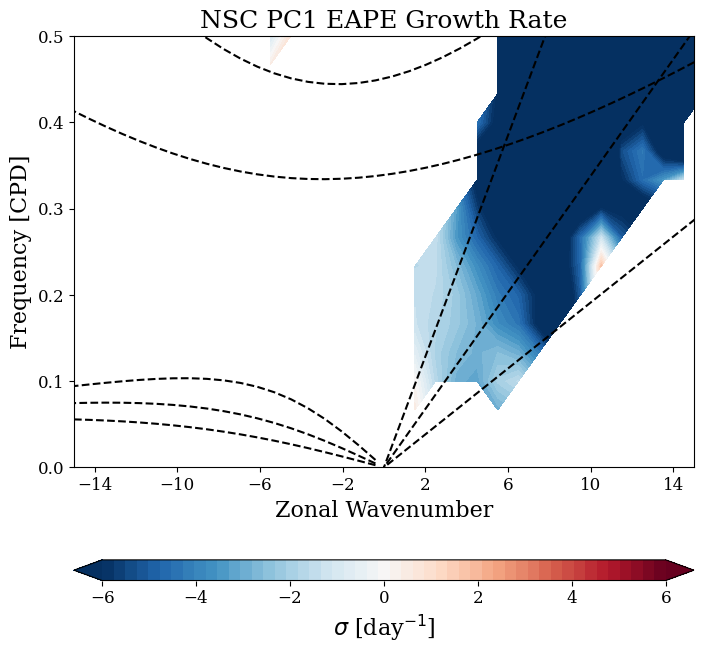

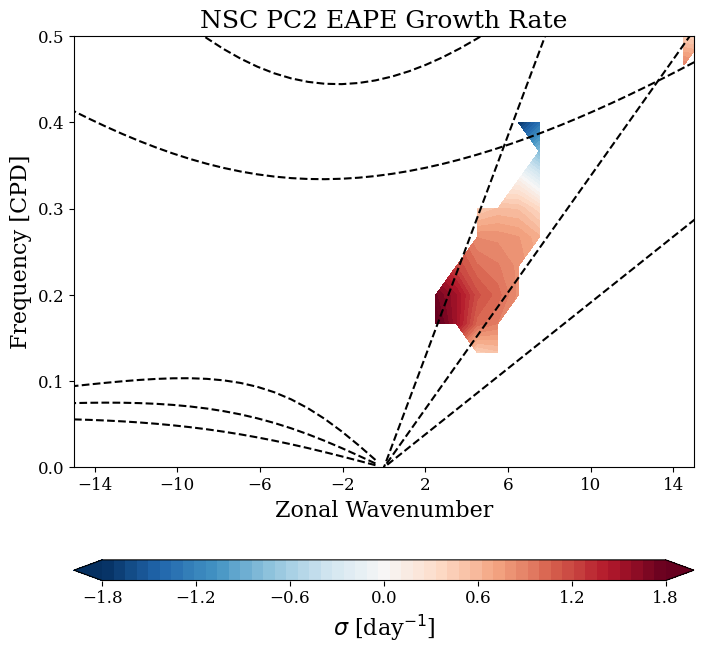

In [15]:
plt.figure(figsize=(8, 8))
c1 = plt.contourf(
    wnm, frm, 
    sigma_filted['pc1'],
    levels=np.linspace(-6, 6),
    cmap="RdBu_r",
    extend='both'
)
for i in range(3):
    plt.plot(wn_ana[3, i, e_cond], fr_ana[3, i, e_cond], 'k--')
    plt.plot(wn_ana[4, i, :], fr_ana[4, i, :], 'k--')
    plt.plot(wn_ana[5, i, :], fr_ana[5, i, :], 'k--')
plt.xticks(np.linspace(-14, 14, 8))
plt.yticks(np.linspace(0, 0.5, 6))
plt.xlim(-15, 15)
plt.ylim(0, 0.5)
plt.xlabel('Zonal Wavenumber')
plt.ylabel('Frequency [CPD]')
plt.title(f'{case} PC1 EAPE Growth Rate')
cbar1 = plt.colorbar(
    c1,
    aspect=30,
    orientation='horizontal',
    label=r'$\sigma$ [day$^{-1}$]'
)
cbar1.set_ticks(np.linspace(-6, 6, 7))
plt.savefig(f'/home/b11209013/2024_Research/MPAS/GrowthRate/image/{case}/PC1_Growth_Rate.png')
plt.show()

plt.figure(figsize=(8, 8))
c2 = plt.contourf(
    wnm, frm, 
    sigma_filted['pc2'],
    levels=np.linspace(-1.8, 1.8),
    cmap="RdBu_r",
    extend='both'
)
for i in range(3):
    plt.plot(wn_ana[3, i, e_cond], fr_ana[3, i, e_cond], 'k--')
    plt.plot(wn_ana[4, i, :], fr_ana[4, i, :], 'k--')
    plt.plot(wn_ana[5, i, :], fr_ana[5, i, :], 'k--')
plt.xticks(np.linspace(-14, 14, 8))
plt.yticks(np.linspace(0, 0.5, 6))
plt.xlim(-15, 15)
plt.ylim(0, 0.5)
plt.xlabel('Zonal Wavenumber')
plt.ylabel('Frequency [CPD]')
plt.title(f'{case} PC2 EAPE Growth Rate')
cbar2 = plt.colorbar(
    c2,
    aspect=30,
    orientation='horizontal',
    label=r'$\sigma$ [day$^{-1}$]'
)
cbar2.set_ticks(np.linspace(-1.8, 1.8, 7))
plt.savefig(f'/home/b11209013/2024_Research/MPAS/GrowthRate/image/{case}/PC2_Growth_Rate.png')